In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

2024-12-10 10:53:40.860321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 10:53:41.431474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Setup and Configuration

In [55]:
# North Carolina data
url = "https://github.com/geo-smart/flood-risk-ml-tutorial/blob/main/North_Carolina_Buildings.zip?raw=true"

# read data into a Pandas dataframe
rawDf = pd.read_csv(url, compression="zip")

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 
df = rawDf.copy( deep=True )

In [56]:
# classify a building as "Residential", "Commercial", or "Other"
df.loc[df["BuildingType"] == "Industrial", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Assembly", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Education", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Government", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Agriculture", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Utility and Misc", "BuildingType"] = 'Other'

# building type distributions
print()
print( df['BuildingType'].value_counts() )
print()
print( 976690/df['BuildingType'].value_counts() )
print()


BuildingType
Residential    976690
Commercial      64029
Other           37425
Name: count, dtype: int64

BuildingType
Residential     1.000000
Commercial     15.253869
Other          26.097261
Name: count, dtype: float64



In [57]:
df = df.drop( columns=['X', 'Y'] )

df = df.dropna()
df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

In [58]:
le = preprocessing.LabelEncoder()

# encode building types
X = df.drop(['BuildingType'], axis=1)
y = df['BuildingType'].values

le.fit( y ) 
y = le.transform( y )
y = y.astype(int)

In [59]:
# encode nearest roads
le2 = preprocessing.LabelEncoder()
le2.fit( X.iloc[:, -1] ) # nearest road type
X.iloc[:, -1] = le2.transform( X.iloc[:, -1] )
X.head()

,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad
359097,160.527600,30173.0,232277.0,0.429110,17.000000,21,45798,18,915,8411,4
119747,150.697572,35468.0,83788.0,0.351656,28.333333,44,13966,6,311,5324,4
46139,381.525728,19820.0,32637.0,0.603428,87.000000,30,5381,0,123,1181,9
618341,140.525700,36443.0,478966.0,0.429380,47.000000,38,118034,39,2607,17352,4
947104,673.464400,41189.0,462582.0,0.409578,20.000000,119,105723,30,2778,17780,4


### Apply Undersampling

In [60]:
print( np.unique( y ) )
print( le.inverse_transform([0,1,2]) )

[0 1 2]
['Commercial' 'Other' 'Residential']


In [71]:
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

# define the undersampling method
nm = NearMiss( version=1 )

# transform the dataset
Xsub, ysub = nm.fit_resample( X.values, y )

In [72]:
for i in range(3):

    ix = np.where( ysub == i )
    print( "Class", i, len(ix[0]) )

Class 0 37424
Class 1 37424
Class 2 37424


### Visualize features

In [73]:
columns = X.columns
columns

Index(['Area', 'MedianIncomeCounty', 'HousingUnitsCounty',
       'HousingDensityCounty', 'Impervious', 'AgCount', 'CmCount', 'GvCount',
       'EdCount', 'InCount', 'OsmNearestRoad'],
      dtype='object')

Text(0.5, 1.0, 'HousingDensityCounty')

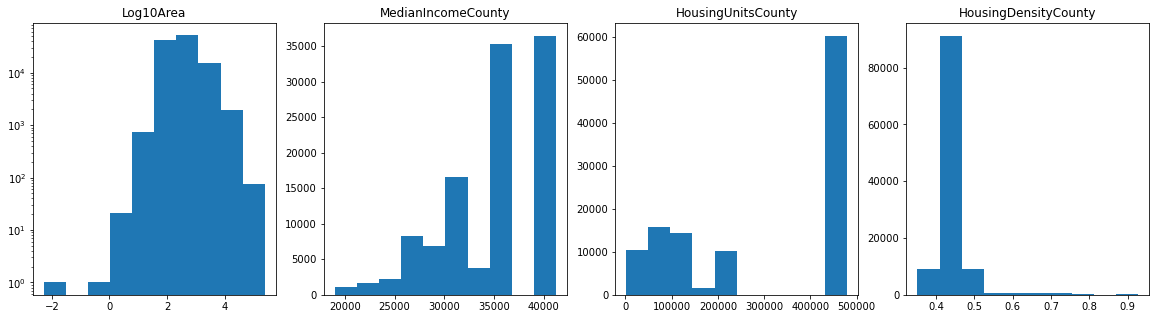

In [74]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].hist( np.log10(Xsub[:,0]) )
axes[0].set_title('Log10' + columns[0])
axes[0].set_yscale('log')

axes[1].hist( Xsub[:,1] )
axes[1].set_title(columns[1])
#axes[1].set_yscale('log')

axes[2].hist( Xsub[:,2] )
axes[2].set_title(columns[2])
#axes[2].set_yscale('log')

axes[3].hist( Xsub[:,3] )
axes[3].set_title(columns[3])
#axes[3].set_yscale('log')

Text(0.5, 1.0, 'GvCount')

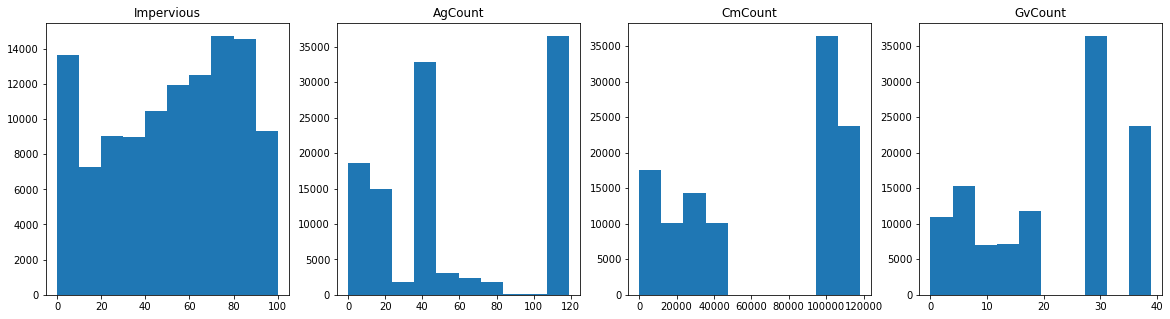

In [75]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].hist( Xsub[:,4] )
axes[0].set_title(columns[4])
#axes[0].set_yscale('log')

axes[1].hist( Xsub[:,5] )
axes[1].set_title(columns[5])
#axes[1].set_yscale('log')

axes[2].hist( Xsub[:,6] )
axes[2].set_title(columns[6])
#axes[2].set_yscale('log')

axes[3].hist( Xsub[:,7] )
axes[3].set_title(columns[7])
#axes[3].set_yscale('log')

Text(0.5, 1.0, 'OsmNearestRoad')

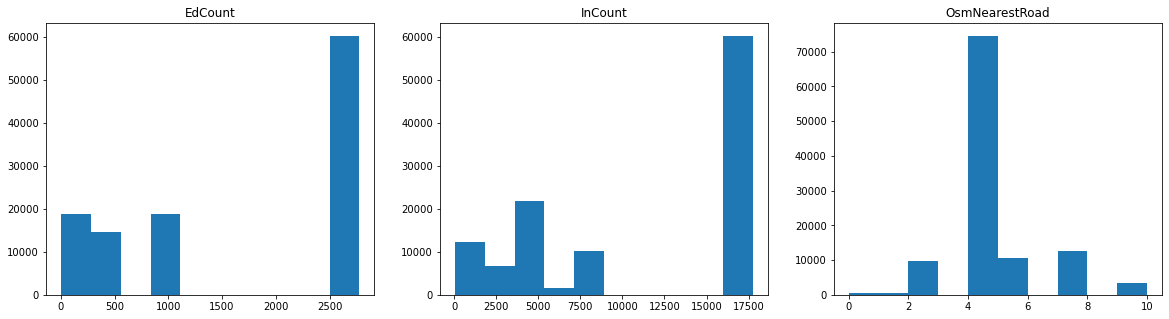

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].hist( Xsub[:,8] )
axes[0].set_title(columns[8])
#axes[0].set_yscale('log')

axes[1].hist( Xsub[:,9] )
axes[1].set_title(columns[9])
#axes[1].set_yscale('log')

axes[2].hist( Xsub[:,10] )
axes[2].set_title(columns[10])
#axes[2].set_yscale('log')

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 2.1000e+01, 7.5100e+02,
        4.2571e+04, 5.1467e+04, 1.5474e+04, 1.9090e+03, 7.7000e+01]),
 array([-2.27018749, -1.50398819, -0.73778889,  0.0284104 ,  0.7946097 ,
         1.560809  ,  2.32700829,  3.09320759,  3.85940689,  4.62560618,
         5.39180548]),
 <BarContainer object of 10 artists>)

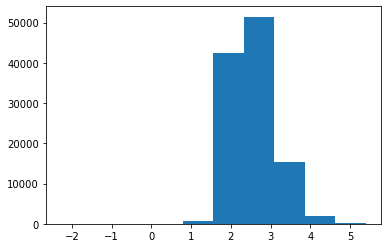

In [77]:
Xsub[:,0] = np.log10(Xsub[:,0])
plt.hist(Xsub[:,0])

In [78]:
columns

Index(['Area', 'MedianIncomeCounty', 'HousingUnitsCounty',
       'HousingDensityCounty', 'Impervious', 'AgCount', 'CmCount', 'GvCount',
       'EdCount', 'InCount', 'OsmNearestRoad'],
      dtype='object')

In [85]:
Xsub.shape

(112272, 11)

In [86]:
# preprocess the data - scaling
scaler = preprocessing.MinMaxScaler()

nearestRoad = Xsub[:,10]
Xscaled = scaler.fit_transform( Xsub )
Xscaled[:,10] = nearestRoad

In [87]:
Xscaled[0,:]

array([5.10391003e-01, 7.24499007e-01, 2.98888602e-01, 1.62156715e-01,
       6.66666667e-03, 0.00000000e+00, 2.26179475e-01, 3.07692308e-01,
       3.21094312e-01, 2.08206516e-01, 7.00000000e+00])

In [89]:
# write scalar and two encoders to pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
    
with open("roadType.pkl", "wb") as f:
    pickle.dump(le2, f)
    
with open("bldType.pkl", "wb") as f:
    pickle.dump(le, f)

In [90]:
Xscaled.shape, ysub.shape

((112272, 11), (112272,))

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xscaled, ysub, test_size=0.2, random_state=42)

print("Training Size:", X_train.shape)
print("Testing Size:", X_test.shape)

# Pickle the array
with open('xTrain_revised.pkl', 'wb') as f:
    pickle.dump(X_train, f) 
with open('xTest_revised.pkl', 'wb') as f:
    pickle.dump(X_test, f) 
with open('yTrain_revised.pkl', 'wb') as f:
    pickle.dump(y_train, f) 
with open('yTest_revised.pkl', 'wb') as f:
    pickle.dump(y_test, f) 

Training Size: (89817, 11)
Testing Size: (22455, 11)


### Bayesian Neural Network

In [14]:
# Load the pickled array
with open('xTrain_revised.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('xTest_revised.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('yTrain_revised.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('yTest_revised.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [92]:
nClasses = 3

# Reset Keras and remove any old models from memory.
import keras.backend as K
K.clear_session()

inputs = keras.layers.Input(shape=X_train.shape[1])
    
hidden1 = keras.layers.Dense(20, activation='relu')(inputs)
hidden2 = keras.layers.Dense(10, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(5, activation='relu')(hidden2)

distribution_params = layers.Dense(nClasses)(hidden3)
outputs = tfp.layers.OneHotCategorical(1)(distribution_params)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 20)                240       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 3)                 18        
                                                                 
 one_hot_categorical (OneHot  ((None, 3),              0         
 Categorical)                 (None, 3))                         
                                                             

2024-12-10 11:44:53.250064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5


In [93]:
from tensorflow.keras.optimizers import RMSprop

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile( loss=nll, optimizer=RMSprop(learning_rate=0.005), metrics=['accuracy'] )

In [94]:
y = tf.one_hot(y_train,nClasses)

In [95]:
history = model.fit( X_train, y, epochs=200, verbose=1, validation_split=0.2, batch_size=128 )

Epoch 1/200


2024-12-10 11:45:06.997418: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7043a8013060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-10 11:45:06.997480: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN Black, Compute Capability 3.5
2024-12-10 11:45:07.009278: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 11:45:07.162116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-12-10 11:45:07.208350: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-10 11:45:07.271374: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 5s 6ms/step - loss: 0.7473 - accuracy: 0.5178 - val_loss: 0.7313 - val_accuracy: 0.5381
Epoch 2/200
562/562 [==============================] - 3s 6ms/step - loss: 0.6502 - accuracy: 0.5929 - val_loss: 0.6186 - val_accuracy: 0.6105
Epoch 3/200
562/562 [==============================] - 3s 6ms/step - loss: 0.6298 - accuracy: 0.6127 - val_loss: 0.6229 - val_accuracy: 0.6132
Epoch 4/200
562/562 [==============================] - 3s 6ms/step - loss: 0.6170 - accuracy: 0.6223 - val_loss: 0.6689 - val_accuracy: 0.6285
Epoch 5/200
562/562 [==============================] - 3s 6ms/step - loss: 0.6106 - accuracy: 0.6285 - val_loss: 0.6367 - val_accuracy: 0.6188
Epoch 6/200
562/562 [==============================] - 3s 6ms/step - loss: 0.6041 - accuracy: 0.6307 - val_loss: 0.6057 - val_accuracy: 0.6415
Epoch 7/200
562/562 [==============================] - 3s 6ms/step - loss: 0.5995 - accuracy: 0.6345 - val_loss: 0.6627 - val_accuracy: 0.6323
Epoch 8/200

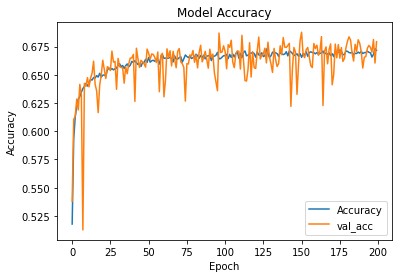

In [96]:
plt.plot( history.history['accuracy'], label="Accuracy")
plt.plot( history.history['val_accuracy'], label="val_acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

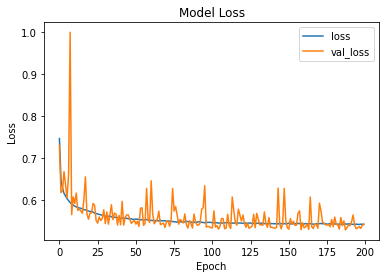

In [97]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [98]:
# serialize weights to HDF5
model.save_weights("bnn_revised.h5")

### Analysis

In [11]:
nClasses = 3
model.load_weights("bnn_revised.h5")

In [136]:
preds = []
p = model( X_test )
en = model( X_test ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )

In [137]:
font = { 'weight' : 'bold', 'size' : 24 }
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


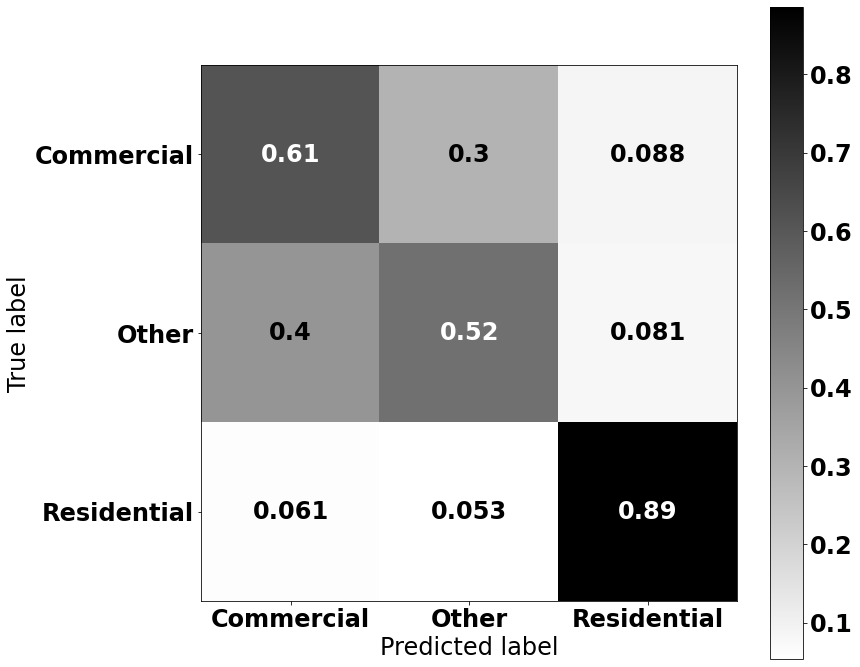

In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 12))

cm = confusion_matrix( y_test.astype(int), preds, normalize='true' )
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]) )
disp.plot(ax=ax, cmap='gist_yarg')

In [139]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

y_test = y_test.astype(int)

print( "Macro F1:", np.round( f1_score(y_test, preds, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(y_test, preds, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(y_test, preds, average='macro'), 4 ))
print( "Accuracy:", np.round( accuracy_score(y_test, preds), 4 ))

Macro F1: 0.669
Macro Precision: 0.6682
Macro Recall: 0.6724
Accuracy: 0.6717


In [103]:
en = np.array(en)

Text(0.5, 1.0, 'Entropy of Incorrect Predictions')

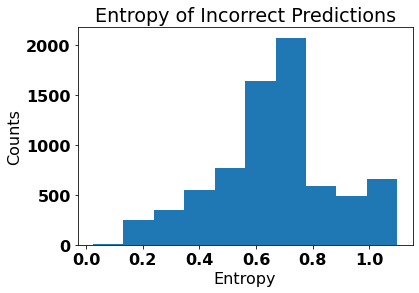

In [106]:
font = {'weight' : 'bold', 'size'   : 16}
plt.rc('font', **font)

correct = np.where( preds == y_test )
incorrect = np.where( preds != y_test )

plt.hist( en[incorrect] )
#plt.hist( en[correct], alpha=0.35 )
#plt.yscale('log')
plt.xlabel( 'Entropy' )
plt.ylabel( 'Counts' )
plt.title( 'Entropy of Incorrect Predictions' )

#### Entropy-Accuracy Evaluation

In [107]:
np.max(en)
preds = np.array(preds)

In [108]:
from sklearn.metrics import balanced_accuracy_score

testValues = np.arange(0.3, 1.1, 0.1)

acc = []
thr = []
pct = []

n = preds.shape[0]

for t in testValues:
    
    ixs = np.where( en <= t )
    y = y_test[ixs]
    x = preds[ixs]
    
    acc.append( balanced_accuracy_score(y,x) )
    thr.append( t )
    pct.append( len(ixs[0])/n )

    print( "Threshold:", t )
    print( "X, Y:", y.shape, x.shape)
    print( "Percent of predictions:", len(ixs[0])/n )
    print( "Balanced Accuracy:", np.round( balanced_accuracy_score(y,x), 4 ))
    print( "Macro F1:", np.round( f1_score(y,x, average='macro'), 4 ))
    print( "Macro Precision:", np.round( precision_score(y,x, average='macro'), 4 ))
    print( "Macro Recall:", np.round( recall_score(y,x, average='macro'), 4 ))
    print()

Threshold: 0.3
X, Y: (5572,) (5572,)
Percent of predictions: 0.24814072589623692
Balanced Accuracy: 0.7551
Macro F1: 0.7551
Macro Precision: 0.7551
Macro Recall: 0.7551

Threshold: 0.4
X, Y: (7930,) (7930,)
Percent of predictions: 0.35315074593631707
Balanced Accuracy: 0.8091
Macro F1: 0.8125
Macro Precision: 0.816
Macro Recall: 0.8091

Threshold: 0.5
X, Y: (10050,) (10050,)
Percent of predictions: 0.447561790247161
Balanced Accuracy: 0.7967
Macro F1: 0.7993
Macro Precision: 0.8028
Macro Recall: 0.7967

Threshold: 0.6000000000000001
X, Y: (12668,) (12668,)
Percent of predictions: 0.5641505232687597
Balanced Accuracy: 0.7642
Macro F1: 0.7662
Macro Precision: 0.7699
Macro Recall: 0.7642

Threshold: 0.7000000000000002
X, Y: (17868,) (17868,)
Percent of predictions: 0.7957247828991316
Balanced Accuracy: 0.717
Macro F1: 0.7151
Macro Precision: 0.716
Macro Recall: 0.717

Threshold: 0.8000000000000003
X, Y: (19869,) (19869,)
Percent of predictions: 0.8848363393453574
Balanced Accuracy: 0.7025

(0.0, 1.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


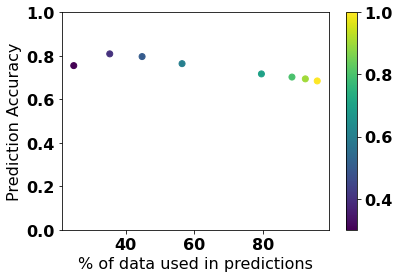

In [109]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 16}
plt.rc('font', **font)

plt.scatter( np.array(pct)*100., acc, c=thr )
plt.colorbar()
plt.xlabel('% of data used in predictions')
plt.ylabel('Prediction Accuracy')
plt.ylim(0,1)

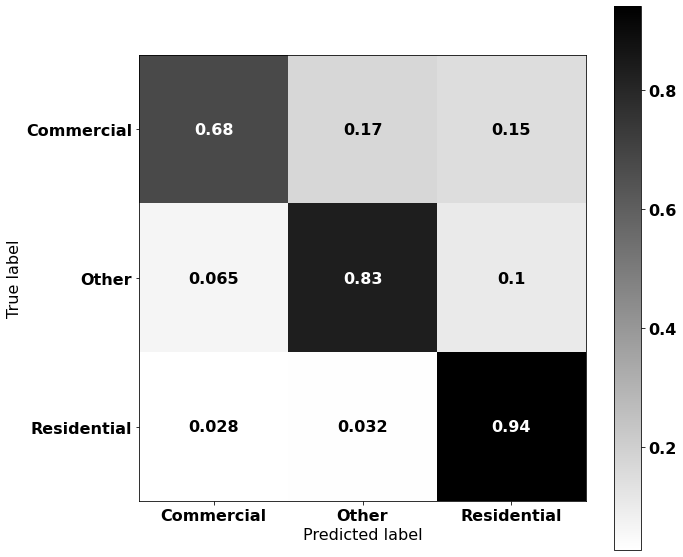

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

th = 0.4

ixs = np.where( en <= th )
y = y_test[ixs]
x = preds[ixs]
    
cm = confusion_matrix( x, y, normalize='true' )

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

In [111]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(x,y), 4 ))
print( "Macro F1:", np.round( f1_score(x,y, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(x,y, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(x,y, average='macro'), 4 ))

Balanced Accuracy: 0.816
Macro F1: 0.8125
Macro Precision: 0.8091
Macro Recall: 0.816


### Where is the model confused?

In [115]:
ix0 = np.where( (preds == y_test) & (en < 0.5) )
ix1 = np.where( (preds != y_test) & (en >= 0.5) )

In [125]:
columns

Index(['Area', 'MedianIncomeCounty', 'HousingUnitsCounty',
       'HousingDensityCounty', 'Impervious', 'AgCount', 'CmCount', 'GvCount',
       'EdCount', 'InCount', 'OsmNearestRoad'],
      dtype='object')

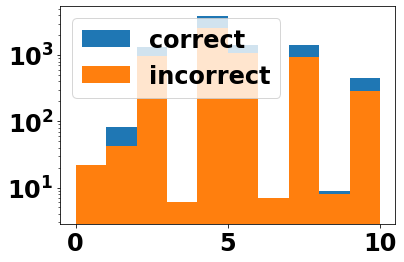

In [147]:
plt.hist( Xsub[ix0[0],10], label='correct' )
plt.hist( Xsub[ix1[0],10], label='incorrect')
plt.legend()
plt.yscale('log')